In [47]:
%matplotlib inline
import numpy as np
from gPhoton.pipeline import execute_pipeline
import pandas as pd
import astropy.units as u
from astropy.coordinates import SkyCoord
import matplotlib.pyplot as plt
from gPhoton.io.fits_utils import get_fits_data, read_wcs_from_fits
from astropy.visualization import ZScaleInterval
import os
import tqdm
import imageio.v2 as imageio
from IPython.display import Image
import astropy.wcs
from gPhoton.coadd import make_shared_wcs, project_to_shared_wcs, bin_projected_weights

Notebook summary: Exploring ideas for image and data representation.

Pipeline steps:
1. Run photometry with extraction on NUV
2. Run photometry with extraction on FUV
3. Run photometry on FUV with NUV source positions
4. Run photometry on NUV with FUV source positions
5. Generate a merged catalog from NUV extractions
6. Generate a merged catalog from FUV extractions
7. Generate a merged catalog from all NUV / FUV detections

In [5]:
eclipse = 23456
datadir = "/Users/cm/github/gphoton2_refactor/gPhoton2/test_data/"
edir = f"e{str(eclipse).zfill(5)}"
filepaths = {}
for band in ['NUV','FUV']:
    bstr = band.lower()[0]
    match_on_fuv_fn = f"{datadir}{edir}/{edir}-{bstr}d-b00-f0120-movie-photom-12_8-mof.csv"
    match_on_nuv_fn = f"{datadir}{edir}/{edir}-{bstr}d-b00-f0120-movie-photom-12_8-mon.csv"
    filepaths[band] = {'mof':match_on_fuv_fn,
                         'mon':match_on_nuv_fn}
filepaths

{'NUV': {'mof': '/Users/cm/github/gphoton2_refactor/gPhoton2/test_data/e23456/e23456-nd-b00-f0120-movie-photom-12_8-mof.csv',
  'mon': '/Users/cm/github/gphoton2_refactor/gPhoton2/test_data/e23456/e23456-nd-b00-f0120-movie-photom-12_8-mon.csv'},
 'FUV': {'mof': '/Users/cm/github/gphoton2_refactor/gPhoton2/test_data/e23456/e23456-fd-b00-f0120-movie-photom-12_8-mof.csv',
  'mon': '/Users/cm/github/gphoton2_refactor/gPhoton2/test_data/e23456/e23456-fd-b00-f0120-movie-photom-12_8-mon.csv'}}

In [6]:
ra_nuv,dec_nuv,x_nuv,y_nuv = pd.read_csv(filepaths['NUV']['mon'],index_col=None)[['ra','dec','xcentroid','ycentroid']].values.T
ra_fuv,dec_fuv,x_fuv,y_fuv = pd.read_csv(filepaths['FUV']['mof'],index_col=None)[['ra','dec','xcentroid','ycentroid']].values.T
print(len(ra_nuv),len(ra_fuv))

4840 3962


In [28]:
nuv_image_fn = '/Users/cm/github/gphoton2_refactor/gPhoton2/test_data/e23456/e23456-nd-b00-ffull-image-r.fits'
fuv_image_fn = '/Users/cm/github/gphoton2_refactor/gPhoton2/test_data/e23456/e23456-fd-b00-ffull-image-r.fits'
image = {'NUV':{'fn':nuv_image_fn,
                'count':get_fits_data(nuv_image_fn,dim=1),
                'flag':get_fits_data(nuv_image_fn,dim=2),
                'edge':get_fits_data(nuv_image_fn,dim=2),
                'wcs':read_wcs_from_fits(nuv_image_fn)[1][0],
                'cat':pd.read_csv(filepaths['NUV']['mon'],index_col=None)[['ra','dec','xcentroid','ycentroid']],
               },
         'FUV':{'fn':fuv_image_fn,
                'count':get_fits_data(fuv_image_fn,dim=1),
                'flag':get_fits_data(fuv_image_fn,dim=2),
                'edge':get_fits_data(fuv_image_fn,dim=2),
                'wcs':read_wcs_from_fits(fuv_image_fn)[1][0],
                'cat':pd.read_csv(filepaths['FUV']['mof'],index_col=None)[['ra','dec','xcentroid','ycentroid']],
               },
        }

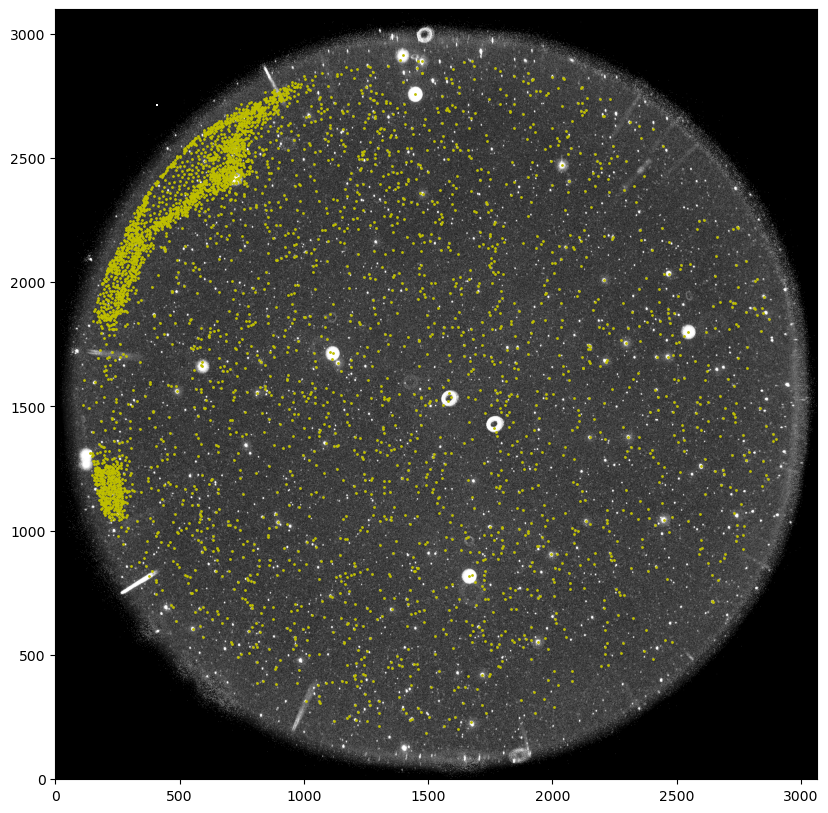

In [26]:
ra_input,dec_input = image['FUV']['wcs'].pixel_to_world_values(x_fuv,y_fuv)
x_shared,y_shared = image['NUV']['wcs'].wcs_world2pix(ra_input,dec_input,1)
plt.figure(figsize=(10,10))
plt.imshow(ZScaleInterval()(image['NUV']['count']), origin='lower',cmap='Greys_r')
plt.plot(x_shared,y_shared,'y.',markersize=2)

In [5]:
c = SkyCoord(ra=ra_fuv*u.degree, dec=dec_fuv*u.degree)
catalog = SkyCoord(ra=ra_nuv*u.degree, dec=dec_nuv*u.degree)
catalog_ix, d2d, d3d = c.match_to_catalog_sky(catalog)

In [6]:
match_radius = 3*4.17e-4 # N * galex pixels in decimal degrees
match_radius

0.001251

In [7]:
mask = np.ones(np.array(d2d).shape)
mask[np.where(np.array(d2d)>match_radius)] = 0

In [8]:
d2d_masked = np.ma.array(d2d,mask=mask)
catalog_ix_masked = np.ma.array(catalog_ix,mask=mask)

Text(0.5, 1.0, 'FUV')

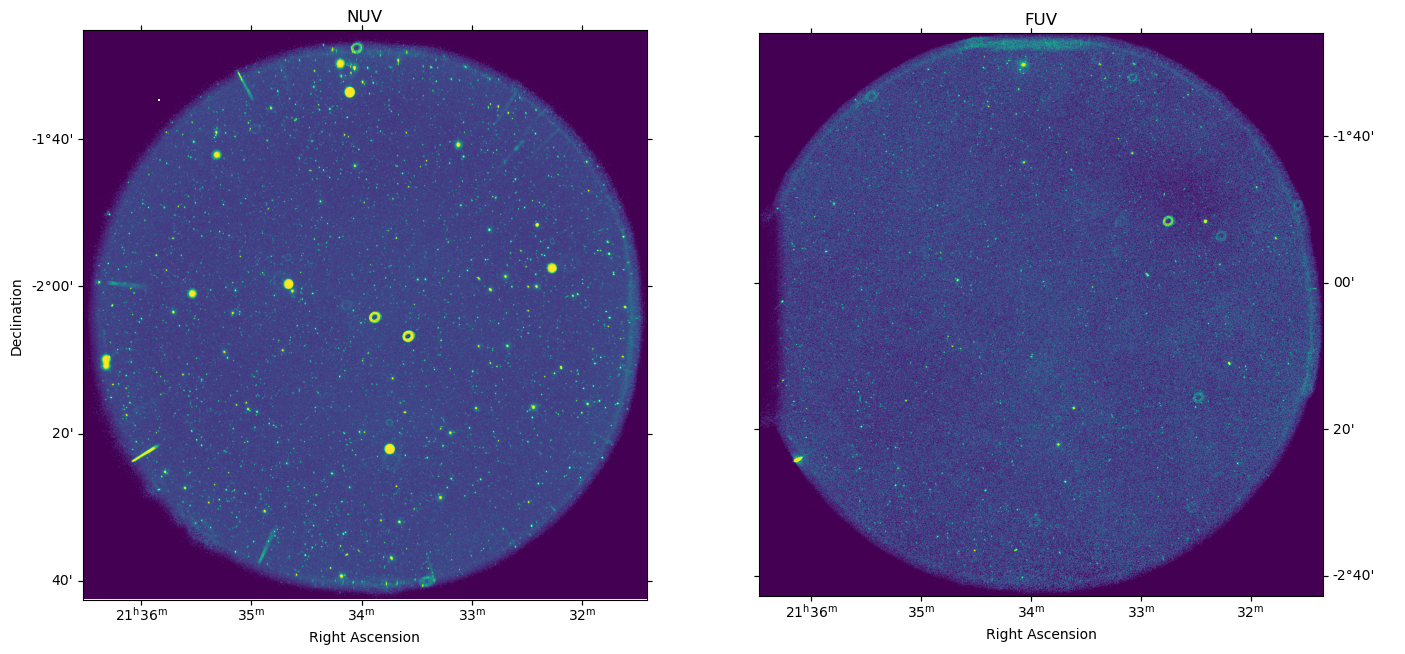

In [9]:
plt.figure(figsize=(16,8))

ax1 = plt.subplot(1,2,1, projection=image['NUV']['wcs'])
ax1.imshow(ZScaleInterval()(image['NUV']['count']), origin='lower')#, vmin=-100., vmax=2000.)
ax1.coords['ra'].set_axislabel('Right Ascension')
ax1.coords['dec'].set_axislabel('Declination')
ax1.set_title('NUV')

ax2 = plt.subplot(1,2,2, projection=image['FUV']['wcs'])
ax2.imshow(ZScaleInterval()(image['FUV']['count']), origin='lower')#, vmin=-2.e-4, vmax=5.e-4)
#ax2.coords['glon'].set_axislabel('Galactic Longitude')
#ax2.coords['glat'].set_axislabel('Galactic Latitude')
ax2.coords['ra'].set_axislabel('Right Ascension')
ax2.coords['dec'].set_axislabel(' ')
ax2.coords['dec'].set_axislabel_position('r')
ax2.coords['dec'].set_ticklabel_position('r')
ax2.set_title('FUV')

In [10]:
from gPhoton.coadd import make_shared_wcs, project_to_shared_wcs, bin_projected_weights

In [11]:
shared_wcs = make_shared_wcs((image['NUV']['wcs'],image['FUV']['wcs']))

In [12]:
proj_nuv = project_to_shared_wcs(nuv_image_fn,shared_wcs,1,apply_mask=False)
pimg_nuv = bin_projected_weights(proj_nuv['x'],proj_nuv['y'],proj_nuv['weight'],proj_nuv['imsz'])

In [13]:
proj_fuv = project_to_shared_wcs(fuv_image_fn,shared_wcs,1,apply_mask=False)
pimg_fuv = bin_projected_weights(proj_fuv['x'],proj_fuv['y'],proj_fuv['weight'],proj_fuv['imsz'])

Text(0.5, 1.0, 'FUV')

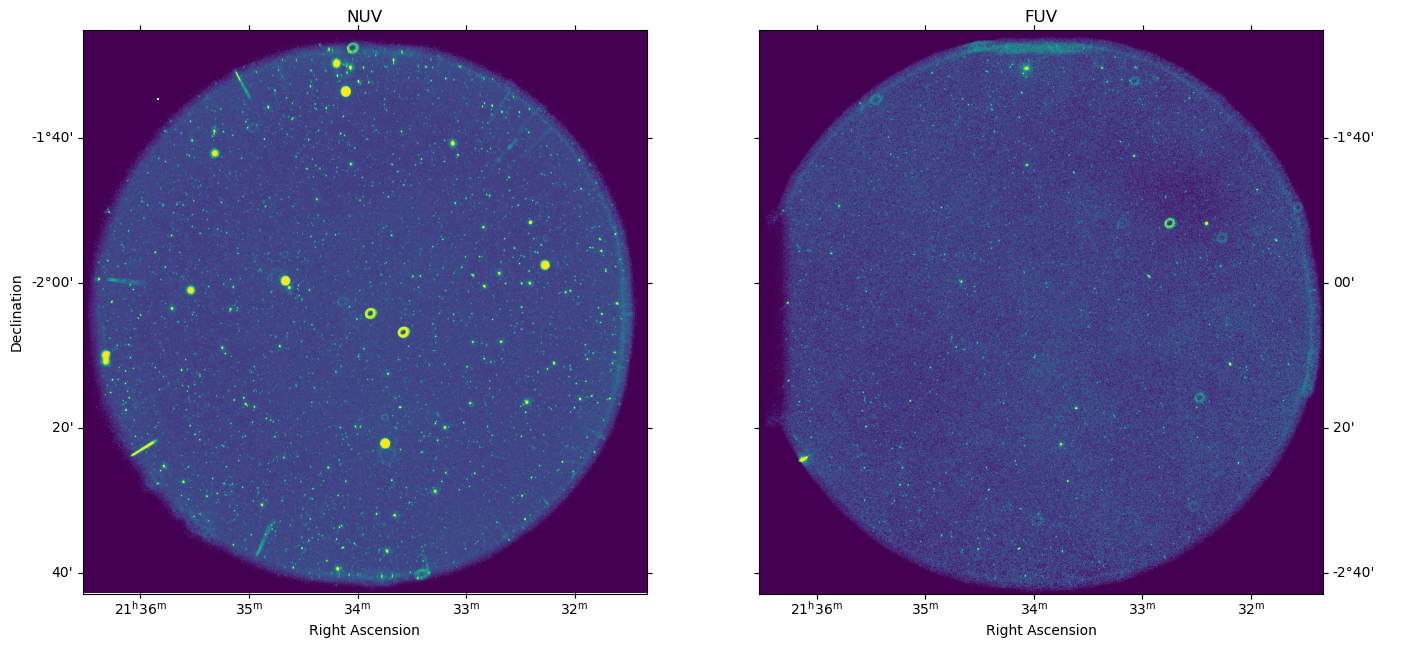

In [14]:
plt.figure(figsize=(16,8))

ax1 = plt.subplot(1,2,1, projection=shared_wcs)
ax1.imshow(ZScaleInterval()(pimg_nuv), origin='lower')#, vmin=-100., vmax=2000.)
ax1.coords['ra'].set_axislabel('Right Ascension')
ax1.coords['dec'].set_axislabel('Declination')
ax1.set_title('NUV')

ax2 = plt.subplot(1,2,2, projection=shared_wcs)
ax2.imshow(ZScaleInterval()(pimg_fuv), origin='lower')#, vmin=-2.e-4, vmax=5.e-4)
#ax2.coords['glon'].set_axislabel('Galactic Longitude')
#ax2.coords['glat'].set_axislabel('Galactic Latitude')
ax2.coords['ra'].set_axislabel('Right Ascension')
ax2.coords['dec'].set_axislabel(' ')
ax2.coords['dec'].set_axislabel_position('r')
ax2.coords['dec'].set_ticklabel_position('r')
ax2.set_title('FUV')

In [61]:
def make_band_gif(data,fn_root,temp_dir,output_dir,overwrite = True,cmap="Greys_r",fps=1,apply_mask=True):
    gif_fn = f'{output_dir}{fn_root}.gif'
    if os.path.exists(gif_fn) and not overwrite:
        return gif_fn
    
    shared_wcs = make_shared_wcs((data['NUV']['wcs'],data['FUV']['wcs']))

    for band in ['NUV','FUV']:
        frame_fn = f'{temp_dir}{fn_root}-{band}-catqa.png'
        if os.path.exists(frame_fn) and not overwrite:
            continue

        proj = project_to_shared_wcs(data[band]['fn'],shared_wcs,1,apply_mask=apply_mask)
        pimg = bin_projected_weights(proj['x'],proj['y'],proj['weight'],proj['imsz'])
        
        plt.figure(figsize=(10,10));
        plt.xticks([])
        plt.yticks([])
        plt.tight_layout()
        plt.imshow(ZScaleInterval()(pimg),cmap=cmap,origin="lower")
        
        ra_input,dec_input = data[band]['wcs'].pixel_to_world_values(data[band]['cat']['xcentroid'].values,
                                                                     data[band]['cat']['ycentroid'].values)
        x_shared,y_shared = shared_wcs.wcs_world2pix(ra_input,dec_input,1)
        plt.plot(x_shared,y_shared,'y.',markersize=2)
            
        plt.savefig(frame_fn)
        plt.close()
    if os.path.exists(f'{output_dir}{fn_root}.gif') and not overwrite:
        pass
    else:
        with imageio.get_writer(gif_fn, mode='I', fps=fps, loop=0) as writer:
            for band in ['NUV','FUV']:
                frame_fn = f'{temp_dir}{fn_root}-{band}-catqa.png'
                image = imageio.imread(f'{frame_fn}')
                writer.append_data(image)
    return gif_fn

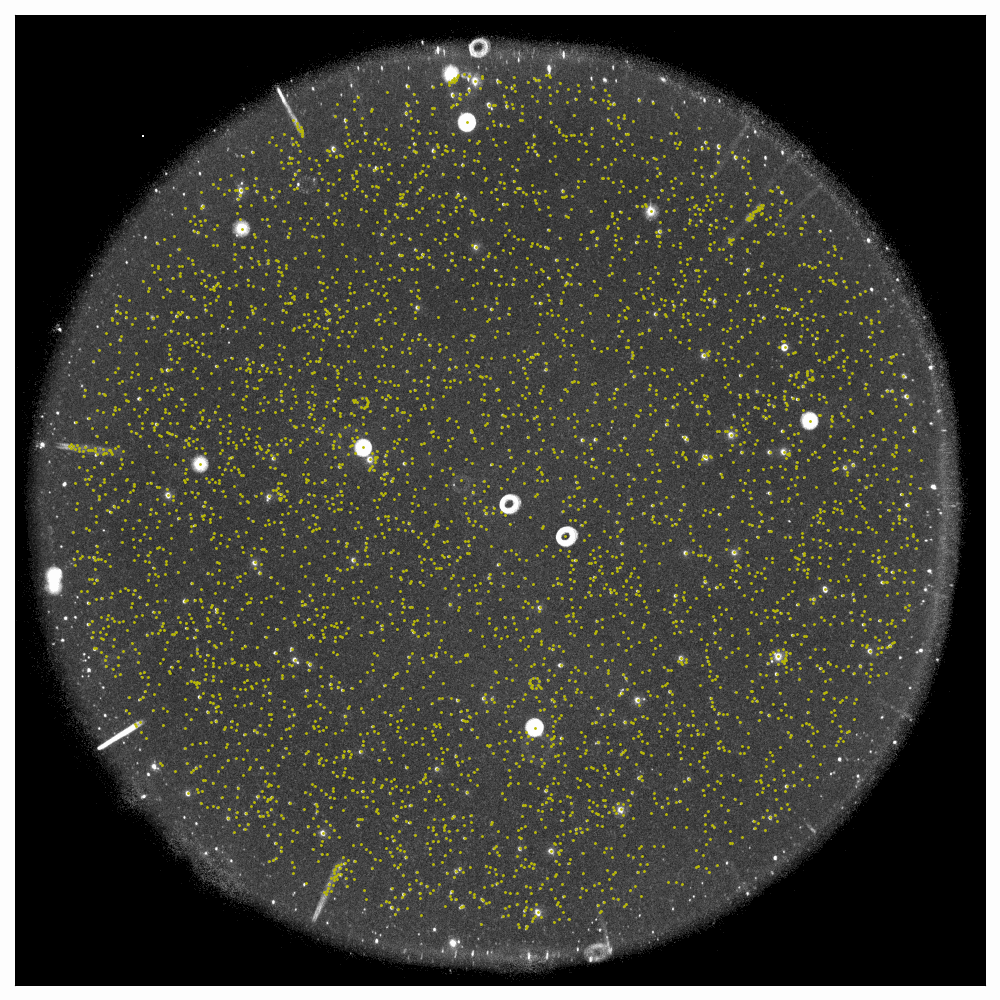

In [62]:
gif_fn = make_band_gif(image,
                  fn_root = 'e23456-fd-catqa',
                  temp_dir = '/Users/cm/github/gphoton2_refactor/gPhoton2/test_data/temp/e23456/',
                  output_dir = '/Users/cm/github/gphoton2_refactor/gPhoton2/test_data/e23456/',
                  overwrite = True,cmap="Greys_r",fps=1,apply_mask=False)
display(Image(data=open(gif_fn,'rb').read(), format='gif'))